# Model Development

In [161]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import tqdm
import re
import pandas_profiling
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-paper')

from ml_utils.preprocessing import target_melt
from ml_utils.tools import format_timedelta
import datetime

In [162]:
# from ml_utils.preprocessing import CategoricalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from category_encoders import MEstimateEncoder, JamesSteinEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.combine import SMOTEEN
from imblearn.over_sampling import ADASYN
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, \
                            roc_curve, \
                            auc, \
                            classification_report, \
                            confusion_matrix, \
                            accuracy_score, \
                            precision_score, \
                            recall_score, \
                            f1_score

In [163]:
import shap
from lime import lime_tabular
shap.initjs()

In [164]:
vcdb = pd.read_excel('data/vcdb_decoded.xlsx')

In [89]:
pd.__version__

'1.0.1'

In [6]:
with open('data/vcdb-enum.json') as f:
    enums = json.load(f)
    
with open('data/vcdb-merged.json') as f:
    schema = json.load(f)

In [7]:
keynames = []
with open('data/vcdb-keynames-real.txt') as f:
    for line in f:
        keynames.append(line.replace('\n', ''))
        

# Creating a configuration file / data dictionary

In [8]:
config = {
    'base_data': {},
    'targets': {}
}

# One-hot encoded features

In [9]:
ohe_cols = [col for col in vcdb if vcdb[col].isin([True, False]).all()]
print('%s hot encoded features'%len(ohe_cols))
      
assert vcdb[ohe_cols].notnull().all().all()
assert len(ohe_cols) == len(vcdb.select_dtypes('bool').columns)

476 hot encoded features


In [10]:
config['base_data']['one-hot encoded'] = ohe_cols

# Null Columns

In [11]:
null_cols = vcdb.columns[vcdb.isnull().all()]
null_cols = [col for col in null_cols if col not in ohe_cols]
print('%s completely null features'%len(null_cols))
config['base_data']['all null'] = null_cols

91 completely null features


Some of these are fine because they are one_hot encoded columns

In [12]:
some_nulls = [col for col in vcdb.columns[vcdb.isnull().any()] if col not in null_cols]
print('%s features with some nulls'%len(some_nulls))
config['base_data']['some null'] = some_nulls

115 features with some nulls


## Null categorical features with an Unknown category
We replace columns with "Unknown" as a value with pandas nulls, this way we can figure out a good imputation strategy for these rather than treat "unknown" as a category, since it is not useful to us.

In [13]:
ukn_cols = [col for col in some_nulls if (vcdb[col].astype(str).str.lower()=='unknown').any()]
for col in ukn_cols:
    vcdb.loc[vcdb[col].astype(str).str.lower()=='unknown', col] = None

assert not vcdb[ukn_cols].apply(lambda col: (col.astype(str).str.lower()=='unknown').any()).any()
config['base_data']['explicitly unknown'] = ukn_cols

# Data Types

### Floats

In [14]:
vcdb.select_dtypes('float64').notnull().sum().sort_values(ascending=False)

attribute.confidentiality.data_total                 4394
attribute.confidentiality.data.amount.Medical        1711
attribute.confidentiality.data.amount.Personal       1192
victim.locations_affected                            1185
victim.revenue.amount                                 505
                                                     ... 
asset.assets.amount.U - Telephone                       0
asset.assets.amount.U - Unknown                         0
asset.assets.amount.U - VoIP phone                      0
attribute.confidentiality.data.amount.Source code       0
asset.assets.amount.E - Other                           0
Length: 149, dtype: int64

In [15]:
vcdb.dtypes.value_counts()

bool       476
float64    149
object      66
int64        1
dtype: int64

In [16]:
float_cols = [col for col in vcdb.select_dtypes('float64') if not vcdb[col].isnull().all()]
len(float_cols)
config['base_data']['floats'] = float_cols

## Free Text

In [17]:
text_cols = [col for col in vcdb if 'notes' in col.lower() or 'summary' in col.lower()]
text_cols += ['reference']
text_cols

['action.environmental.notes',
 'action.error.notes',
 'action.hacking.notes',
 'action.malware.notes',
 'action.misuse.notes',
 'action.physical.notes',
 'action.social.notes',
 'action.unknown.notes',
 'asset.notes',
 'attribute.availability.notes',
 'attribute.confidentiality.notes',
 'attribute.integrity.notes',
 'discovery_notes',
 'impact.notes',
 'notes',
 'plus.analyst_notes',
 'plus.event_chain.summary',
 'plus.pci.notes',
 'summary',
 'victim.notes',
 'victim.secondary.notes',
 'reference']

In [18]:
vcdb[text_cols].notnull().sum()

action.environmental.notes            1
action.error.notes                  299
action.hacking.notes                192
action.malware.notes                102
action.misuse.notes                 118
action.physical.notes                30
action.social.notes                  60
action.unknown.notes                  5
asset.notes                         173
attribute.availability.notes        114
attribute.confidentiality.notes     727
attribute.integrity.notes           234
discovery_notes                     415
impact.notes                        133
notes                               423
plus.analyst_notes                  167
plus.event_chain.summary              0
plus.pci.notes                        0
summary                            7329
victim.notes                         62
victim.secondary.notes               74
reference                          7379
dtype: int64

## Text cleaning

In [19]:
cat_and_text_cols = vcdb.select_dtypes('O').columns
for col in cat_and_text_cols:
    vcdb[col] = (
        vcdb[col]
            .fillna('placeholder_nan')
            .astype(str)
            .str.lower()
            .replace('placeholder_nan', np.nan)
    )

## Categoricals

In [20]:
{col: vcdb[col].unique() for col in vcdb if 'cve' in col}

{'action.hacking.cve': array([nan, 'cve-2008-4250', 'heartbleed', 'cve-2012-0507',
        'unknown vuln', 'cve-2016-6483', 'cve unknown', 'cve-2012-5385',
        'cve-2014-0160', 'cve-2017-5638', 'cve-2012-4969', 'cve-2013-0632',
        'cve-2013-1347,cve-2013-2423,cve-2013-1493', 'cve-2017-0144',
        'wordpress'], dtype=object),
 'action.malware.cve': array([nan, 'cve-2010-0249',
        'cve-2009-3129, cve-2010-3333, cve-2012-0158, cve-2011-3544',
        'cve-2013-0640,cve-2013-0641', 'cve-2012-4681;cve-2013-2423',
        'cve-2013-3893', 'cve 2012-4792',
        'cve-2013-1347, cve-2013-2423, cve-2013-1493', 'cve-2012-4681'],
       dtype=object)}

In [21]:
feature_counts = {}
for col in vcdb.select_dtypes('O'):
    if 'notes' not in col.lower() and col not in ohe_cols:
        feature_counts[col]= vcdb[col].nunique()
feature_counts

{'action.hacking.cve': 14,
 'action.malware.cve': 8,
 'action.malware.name': 21,
 'campaign_id': 10,
 'control_failure': 1,
 'incident_id': 7829,
 'plus.analyst': 69,
 'plus.asset.total': 3,
 'plus.attribute.confidentiality.credit_monitoring': 5,
 'plus.attribute.confidentiality.data_abuse': 3,
 'plus.attribute.confidentiality.data_misuse': 4,
 'plus.attribute.confidentiality.partner_data': 2,
 'plus.f500': 6,
 'plus.github': 4344,
 'plus.master_id': 7832,
 'plus.sub_source': 4,
 'reference': 5925,
 'schema_version': 2,
 'source_id': 1,
 'summary': 6936,
 'victim.industry': 670,
 'victim.region': 38,
 'victim.secondary.victim_id': 234,
 'victim.state': 97,
 'victim.victim_id': 5616,
 'victim.industry3': 115,
 'victim.industry.name': 21,
 'pattern': 10,
 'security_incident': 3,
 'impact.overall_rating': 4,
 'impact.iso_currency_code': 10,
 'confidence': 4,
 'victim.employee_count': 11,
 'victim.country': 134,
 'victim.revenue.iso_currency_code': 2,
 'victim.orgsize': 2,
 'attribute.avai

In [22]:
vcdb[feature_counts.keys()]

,action.hacking.cve,action.malware.cve,action.malware.name,campaign_id,control_failure,incident_id,plus.analyst,plus.asset.total,plus.attribute.confidentiality.credit_monitoring,plus.attribute.confidentiality.data_abuse,...,targeted,cost_corrective_action,asset.cloud,asset.accessibility,asset.country,plus.analysis_status,plus.attack_difficulty_initial,plus.attack_difficulty_legacy,plus.attack_difficulty_subsequent,plus.unknown_unknowns
0,NaN,NaN,NaN,NaN,NaN,0001aa7f-c601-424a-b2b8-be6c9f5164e7,swidup,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,0008dadb-e83d-4278-a19a-cee01610cf43,swidup,NaN,u,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,000d403e-2dc9-4ea7-9294-bd3938d1c3c7,swidup,NaN,y,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,0012cc25-9167-40d8-8fe3-3d0dfd8fb6bb,swidup,no,u,y,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,00163384-b4d7-46d5-9e6f-543dfb00f598,swidup,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7828,NaN,NaN,NaN,NaN,NaN,b533254c-4713-4fe7-a9f8-412abb4ec664,robert-topper,NaN,u,NaN,...,NaN,NaN,NaN,NaN,NaN,finalized,NaN,NaN,NaN,NaN
7829,NaN,NaN,NaN,NaN,NaN,ffd31fe4-976b-48ca-a111-ef84ebab9b0f,swidup,NaN,y,NaN,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
7830,NaN,NaN,NaN,NaN,NaN,ffda2281-8053-4315-b613-330eb09a4bee,swidup,no,u,y,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN
7831,NaN,NaN,NaN,NaN,NaN,ffdc6655-e421-4bec-835f-1bdfec4f6c70,swidup,no,u,u,...,NaN,NaN,NaN,NaN,NaN,first pass,NaN,NaN,NaN,NaN


In [23]:
def id_generator(dict_var, key):
    """
    Based.
    https://stackoverflow.com/questions/21028979/recursive-iteration-through-nested-json-for-specific-key-in-python
    """
    for k, v in dict_var.items():
        if k == key:
            yield v
        elif isinstance(v, dict):
            for id_val in id_generator(v, key):
                yield id_val

In [24]:
enums = set()
for enum in id_generator(schema,'enum'):
    enums.add(tuple(enum))

len(enums)

66

In [25]:
pd.Categorical(vcdb['security_incident']).categories

Index(['confirmed', 'near miss', 'suspected'], dtype='object')

# Target Variable Analysis

We start by having at some Incident Description Enumerations to see what is feasible.

#### SECURITY_INCIDENT
- Confirmed: Yes - Confirmed
- Suspected: Suspected
- False positive: False positive (response triggered, but no incident)
- Near miss: Near miss (actions did not compromise asset)

In [26]:
config['targets']['All'] = []

In [27]:
schema['properties']['security_incident']

{'type': 'string',
 'description': 'Confirmed incident?',
 'enum': ['Confirmed', 'Suspected', 'Near miss', 'False positive']}

In [28]:
vcdb['security_incident'].value_counts(dropna=False)

confirmed    7759
suspected      67
near miss       6
NaN             1
Name: security_incident, dtype: int64

In [29]:
config['targets']['All'].append('security_incident')

In [30]:
impact_cols = [col for col in vcdb if col.startswith('impact')]

In [31]:
vcdb[[col for col in vcdb if col.startswith('impact')]].notnull().sum()

impact.loss.amount             0
impact.notes                 133
impact.overall_amount         80
impact.overall_max_amount      1
impact.overall_min_amount      2
impact.overall_rating         27
impact.iso_currency_code     197
dtype: int64

In [32]:
vcdb['impact.overall_rating'].value_counts(dropna=False)

NaN              7806
distracting        13
damaging            8
painful             5
insignificant       1
Name: impact.overall_rating, dtype: int64

In [33]:
config['targets']['All'] += [col for col in vcdb if col.startswith('impact')]

# Predicting C-I-A outcomes

In [34]:
cia_cols = [col for col in vcdb if col.startswith('attribute.')]
config['targets']['All CIA'] = cia_cols

Data Disclosure looks promising as a decision outcome: while there is a class imbalance it is not as extreme as that of security_incidents

In [35]:
vcdb['attribute.confidentiality.data_disclosure'].value_counts()

yes            5076
potentially    1884
no               76
Name: attribute.confidentiality.data_disclosure, dtype: int64

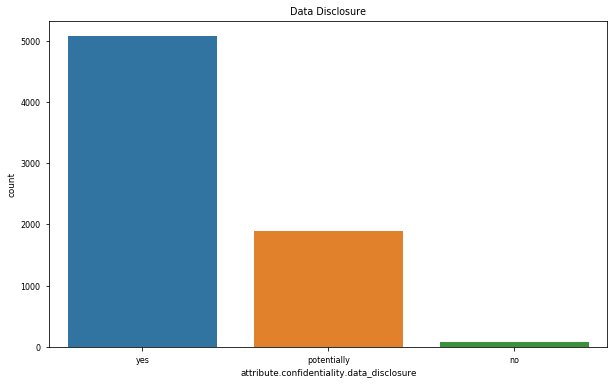

In [36]:
plt.figure(figsize=(10,6))
plt.title('Data Disclosure')
ax = sns.countplot(vcdb['attribute.confidentiality.data_disclosure'])
plt.savefig('figs/data_disclosure_classes.png')

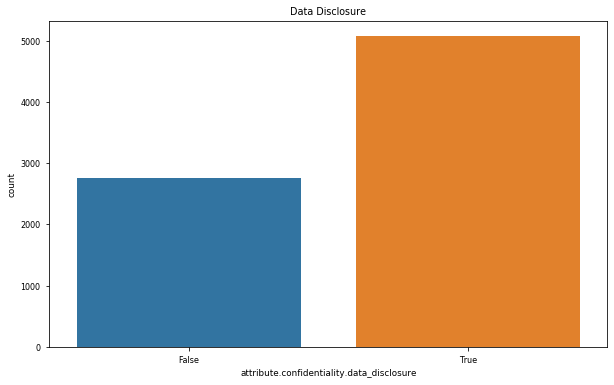

In [37]:
plt.figure(figsize=(10,6))
plt.title('Data Disclosure')
ax = sns.countplot(vcdb['attribute.confidentiality.data_disclosure']=='yes')
plt.savefig('figs/data_disclosure_bool.png')

In [38]:
config['targets']['data_disclosure'] = 'attribute.confidentiality.data_disclosure'

Availability Duration does not seem promising as a decision outcome

In [39]:
config['targets']['All'] += [col for col in vcdb if col.startswith('attribute')]

In [40]:
vcdb['attribute.Confidentiality'].value_counts()

True     7249
False     584
Name: attribute.Confidentiality, dtype: int64

In [41]:
[col for col in vcdb if col.startswith('attribute.confidentiality') and 'variety' in col]

['attribute.confidentiality.data.variety.Bank',
 'attribute.confidentiality.data.variety.Classified',
 'attribute.confidentiality.data.variety.Copyrighted',
 'attribute.confidentiality.data.variety.Credentials',
 'attribute.confidentiality.data.variety.Digital certificate',
 'attribute.confidentiality.data.variety.Internal',
 'attribute.confidentiality.data.variety.Medical',
 'attribute.confidentiality.data.variety.Other',
 'attribute.confidentiality.data.variety.Payment',
 'attribute.confidentiality.data.variety.Personal',
 'attribute.confidentiality.data.variety.Secrets',
 'attribute.confidentiality.data.variety.Source code',
 'attribute.confidentiality.data.variety.System',
 'attribute.confidentiality.data.variety.Unknown',
 'attribute.confidentiality.data.variety.Virtual currency']

In [42]:
vcdb['attribute.Integrity'].value_counts()

False    5998
True     1835
Name: attribute.Integrity, dtype: int64

In [43]:
[col for col in vcdb if col.startswith('attribute.integrity')]

['attribute.integrity.notes',
 'attribute.integrity.variety.Alter behavior',
 'attribute.integrity.variety.Created account',
 'attribute.integrity.variety.Defacement',
 'attribute.integrity.variety.Fraudulent transaction',
 'attribute.integrity.variety.Hardware tampering',
 'attribute.integrity.variety.Log tampering',
 'attribute.integrity.variety.Misrepresentation',
 'attribute.integrity.variety.Modify configuration',
 'attribute.integrity.variety.Modify data',
 'attribute.integrity.variety.Modify privileges',
 'attribute.integrity.variety.Other',
 'attribute.integrity.variety.Repurpose',
 'attribute.integrity.variety.Software installation',
 'attribute.integrity.variety.Unknown']

In [44]:
vcdb['attribute.Availability'].value_counts()

False    5486
True     2347
Name: attribute.Availability, dtype: int64

In [45]:
[col for col in vcdb if col.startswith('attribute.availability')]

['attribute.availability.duration.value',
 'attribute.availability.notes',
 'attribute.availability.variety.Acceleration',
 'attribute.availability.variety.Degradation',
 'attribute.availability.variety.Destruction',
 'attribute.availability.variety.Interruption',
 'attribute.availability.variety.Loss',
 'attribute.availability.variety.Obscuration',
 'attribute.availability.variety.Other',
 'attribute.availability.variety.Unknown',
 'attribute.availability.duration.unit']

In [46]:
vcdb['attribute.availability.duration.value'].notnull().sum()

106

In [47]:
vcdb['control_failure'].value_counts(dropna=False)

NaN                             7832
single factor authentication       1
Name: control_failure, dtype: int64

## Predicting Pattern Outcomes

In [48]:
vcdb['pattern'].value_counts()

miscellaneous errors      1812
privilege misuse          1597
lost and stolen assets    1460
everything else           1026
web applications           896
payment card skimmers      278
crimeware                  267
cyber-espionage            247
denial of service          162
point of sale               88
Name: pattern, dtype: int64

In [49]:
config['targets']['All'].append('pattern')

In [50]:
pattern_cols = [col for col in vcdb if col.startswith('pattern.')]
pattern_cols

['pattern.Point of Sale',
 'pattern.Web Applications',
 'pattern.Privilege Misuse',
 'pattern.Lost and Stolen Assets',
 'pattern.Miscellaneous Errors',
 'pattern.Crimeware',
 'pattern.Payment Card Skimmers',
 'pattern.Denial of Service',
 'pattern.Cyber-Espionage',
 'pattern.Everything Else']

In [51]:
vcdb[pattern_cols].sum(axis=1).value_counts()

1    7732
2     101
dtype: int64

In [52]:
target_melt(vcdb, pattern_cols)['target'].value_counts(dropna=False)

Miscellaneous Errors      1812
Privilege Misuse          1604
Lost and Stolen Assets    1505
Everything Else           1026
Web Applications           900
Payment Card Skimmers      290
Cyber-Espionage            280
Crimeware                  267
Denial of Service          162
Point of Sale               88
Name: target, dtype: int64

In [53]:
config['targets']['All'] += pattern_cols

## Asset Cols

In [54]:
asset_cols = [col for col in vcdb if col.startswith('asset.')]
len(asset_cols)

220

## Actions as Outcomes or Features

In [55]:
action_cols = [col for col in vcdb if col.startswith('action.')]

In [56]:
vcdb['action.Social'].value_counts()

False    7318
True      515
Name: action.Social, dtype: int64

#### Action Results are very null

In [57]:
vcdb[[col for col in vcdb if col.startswith('action.') and 'result' in col]].sum(axis=1).value_counts()

0    7555
1     199
2      77
3       2
dtype: int64

#### Action Variety Cols  
Potentially useful for making predictions

Should we melt these to create separate records

In [58]:
action_variety_cols = [col for col in vcdb if col.startswith('action.') and 'variety' in col]
len(action_variety_cols)

155

In [59]:
vcdb[action_variety_cols].sum(axis=1).value_counts()

1     6273
2      935
0      210
3      172
13      88
9       74
4       42
5       26
6        9
7        3
8        1
dtype: int64

In [60]:
target_melt(vcdb, action_variety_cols, split=False)['target'].value_counts()

action.hacking.variety.Unknown                1334
action.physical.variety.Theft                 1128
action.misuse.variety.Privilege abuse         1110
action.error.variety.Misdelivery               910
action.error.variety.Loss                      391
                                              ... 
action.environmental.variety.Humidity            1
action.error.variety.Capacity shortage           1
action.error.variety.Misinformation              1
action.environmental.variety.Fire                1
action.hacking.variety.Reverse engineering       1
Name: target, Length: 109, dtype: int64

#### Action Vector Cols  
Potentially useful for making predictions

Should we melt these to create separate records

In [61]:
action_vector_cols = [col for col in vcdb if col.startswith('action.') and 'vector' in col]
len(action_vector_cols)

66

In [62]:
vcdb[action_vector_cols].sum(axis=1).value_counts()

1    6797
2     535
3     251
0     217
4      29
5       3
6       1
dtype: int64

#### Action Result Cols  
Potentially useful for making predictions

Should we melt these to create separate records

In [63]:
action_result_cols = [col for col in vcdb if col.startswith('action.') and 'result' in col]

In [64]:
target_melt(vcdb, action_result_cols, split=False)['target'].shape

(359,)

In [65]:
target_melt(vcdb, action_result_cols, split=False)['target'].value_counts()

action.misuse.result.Exfiltrate      82
action.hacking.result.Exfiltrate     63
action.physical.result.Exfiltrate    55
action.hacking.result.Infiltrate     49
action.malware.result.Exfiltrate     30
action.social.result.Exfiltrate      21
action.social.result.Infiltrate      15
action.malware.result.Infiltrate     14
action.physical.result.Infiltrate    10
action.misuse.result.Infiltrate       5
action.unknown.result.Infiltrate      5
action.unknown.result.Exfiltrate      4
action.social.result.Elevate          3
action.hacking.result.Elevate         1
action.physical.result.Elevate        1
action.malware.result.Elevate         1
Name: target, dtype: int64

In [66]:
target_melt(vcdb, action_vector_cols, split=False)['target'].value_counts()

action.error.vector.Unknown                  1301
action.hacking.vector.Web application        1028
action.misuse.vector.LAN access              1026
action.error.vector.Carelessness              895
action.hacking.vector.Unknown                 769
                                             ... 
action.malware.vector.Removable media           2
action.malware.vector.Software update           2
action.social.vector.Removable media            1
action.social.vector.IM                         1
action.physical.vector.Visitor privileges       1
Name: target, Length: 64, dtype: int64

In [67]:
vcdb[action_vector_cols].sum(axis=1).value_counts()

1    6797
2     535
3     251
0     217
4      29
5       3
6       1
dtype: int64

### High Level Action
Potentially quite useful as a target variable?

i.e given properties about an organisation, what actions are most likely?

In [68]:
action_target_cols = [col for col in vcdb if col.startswith('action') and col.count('.')==1]
target_melt(vcdb, action_target_cols)['target'].value_counts(dropna=False)

Error            2266
Hacking          2078
Misuse           1604
Physical         1517
Malware           633
Social            515
Unknown           233
Environmental       8
Name: target, dtype: int64

## plus

In [69]:
plus_cia_cols = [col for col in vcdb if col.startswith('plus.') and ('confidentiality' in col.lower() or 'integrity' in col.lower() or 'availability' in col.lower())]

## Fortune 500 company

In [70]:
vcdb['plus.f500'].value_counts(dropna=False)

NaN      6751
n         861
u         152
y          62
no          5
false       1
yes         1
Name: plus.f500, dtype: int64

In [71]:
vcdb['plus.f500'] = (
    vcdb['plus.f500']
        .fillna('u')
        .map({'y': True,
              'yes': True,
              'n': False,
              'no': False,
              'false': False,
              'u': None
             })
)

In [72]:
vcdb['plus.f500'].value_counts()

False    867
True      63
Name: plus.f500, dtype: int64

# Model 1: Predicting Likelihood of Data Disclosure

In [73]:
id_cols = [col for col in vcdb if '_id' in col]
id_cols += ['plus.github']

In [74]:
y = (vcdb['attribute.confidentiality.data_disclosure'] == 'yes').astype(int)

In [75]:
y.value_counts()

1    5076
0    2757
Name: attribute.confidentiality.data_disclosure, dtype: int64

In [76]:
dropped_cols = (
    id_cols + 
    text_cols + 
    cia_cols + 
    impact_cols + 
    pattern_cols + 
    null_cols + 
    plus_cia_cols + 
    ['pattern', 'security_incident', 'plus.analyst', 'plus.analysis_status', 'schema_version', 'targeted']
)


In [77]:
X = (
    vcdb
        .copy()
        .drop(labels = dropped_cols, axis=1)
)
X['victim.industry2'] = X['victim.industry2'].astype(str)
assert X.select_dtypes('int64').empty
cat_cols = list(X.select_dtypes('O').columns)

In [78]:
X_noaction = (
    vcdb
        .copy()
        .drop(labels = dropped_cols + action_cols, axis=1)
)
X_noaction['victim.industry2'] = X_noaction['victim.industry2'].astype(str)
assert X_noaction.select_dtypes('int64').empty

In [79]:
X_noasset = (
    vcdb
        .copy()
        .drop(labels = dropped_cols + asset_cols, axis=1)
)
X_noasset['victim.industry2'] = X_noasset['victim.industry2'].astype(str)
assert X_noasset.select_dtypes('int64').empty

In [80]:
X_noactionasset = (
    vcdb
        .copy()
        .drop(labels = dropped_cols + asset_cols + action_cols, axis=1)
)
X_noactionasset['victim.industry2'] = X_noactionasset['victim.industry2'].astype(str)
assert X_noactionasset.select_dtypes('int64').empty

# Comparison of several different models

In [144]:
def compare_models(data, labels, exc_cols=[], title='Receiver Operating Characteristic', figsize=(8,5)):
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
    X_train.is_copy = None
    X_val.is_copy = None
    cat_cols = list(data.select_dtypes('O').columns)

    preprocessor = Pipeline(([
        ('encoder', MEstimateEncoder(cols=[col for col in cat_cols if col not in exc_cols])),
        ('imputer', IterativeImputer(verbose=2))
    ]))
    sampler = ADASYN()

    X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)
    X_val_preprocessed = preprocessor.transform(X_val)
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_preprocessed, y_train)
    
    models = {
        'XGBoost': {
            'model': XGBClassifier(),
            'c_line' : 'b'
        },
        'Random Forest': {
            'model': RandomForestClassifier(),
            'c_line': 'g'
        },
        'SVM': {
            'model': SVC(probability=True),
            'c_line': 'm'
        },
        'Naive Bayes': {
            'model': GaussianNB(),
            'c_line': 'y'
        }
    }
    
    names = []
    roc_aucs = []
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    

    fig = plt.figure(figsize=figsize)

    for model_name, model in models.items():

        t0 = datetime.datetime.now()

        print('Fitting %s...\n'%model_name)

        clf = model['model']
        
        if model_name == 'Naive Bayes':
            scaler = MinMaxScaler()
            x_train = scaler.fit_transform(X_train_resampled)
            x_test = scaler.transform(X_val_preprocessed)
        else:
            x_train = X_train_resampled
            x_test = X_val_preprocessed
        y_train = y_train_resampled
        y_test = y_val

        clf.fit(x_train, y_train)

        print('%s Fitted!'%model_name)
        print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))

        print('---------------------------------------------------')
        print('Predicting on validation data...')
        y_pred_proba = clf.predict_proba(x_test)[:,1]
        y_pred = clf.predict(x_test)

        print('Predictions Completed')
        print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
        print('---------------------------------------------------')
        
        names.append(model_name)
        
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        roc_aucs.append(roc_auc)
#         models[model_name]['roc-auc'] = roc_auc

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
#         models[model_name]['accuracy'] = accuracy

        precision = precision_score(y_test, y_pred)
        precisions.append(precision)
#         models[model_name]['precision'] = precision

        recall = recall_score(y_test, y_pred)
        recalls.append(recall)
#         models[model_name]['recall'] = recall

        f1  = f1_score(y_test, y_pred)
        f1s.append(f1)
#         models[model_name]['f1 score'] = f1


        print('ROC-AUC Score: {:.2%}'.format(roc_auc))
        print('Accuracy Score: {:.2%}'.format(accuracy))
        print('Precision Score: {:.2%}'.format(precision))
        print('Recall Score: {:.2%}'.format(recall))
        print('F1 Score: {:.2%}'.format(f1))
        print('---------------------------------------------------')
        print('Classification Report:')
        print(classification_report(y_test, y_pred))
        print('---------------------------------------------------')
        print('\nConfusion Matrix:')
        confusion = pd.DataFrame(confusion_matrix(y_test, y_pred)).loc[range(2), range(2)]
        print(confusion)
        print('\n\n===================================================')
        fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
        # fpr, tpr, threshold = roc_curve(y_val, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, models[model_name]['c_line'], label = '%s (AUC = %0.2f)' % (model_name, roc_auc))
    
    results = pd.DataFrame({
        'Model Name': names,
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1 Score': f1s,
        'ROC-AUC': roc_aucs
    })
    # make the plot
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(title)
    plt.savefig('figs/results_figs/%s.png'%title.replace(' ', '_'))
    plt.show()
    
    return results

### With Action Columns

[IterativeImputer] Completing matrix with shape (6266, 468)
[IterativeImputer] Ending imputation round 1/10, elapsed time 123.84
[IterativeImputer] Change: 175306.24004450365, scaled tolerance: 130000000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1567, 468)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.19
Fitting XGBoost...

XGBoost Fitted!
Total Time Elapsed - 0:0:3
---------------------------------------------------
Predicting on validation data...
Predictions Completed
Total Time Elapsed - 0:0:3
---------------------------------------------------
ROC-AUC Score: 83.23%
Accuracy Score: 78.30%
Precision Score: 80.48%
Recall Score: 87.36%
F1 Score: 83.78%
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       562
           1       0.80      0.87      0.84      1005

    accuracy       

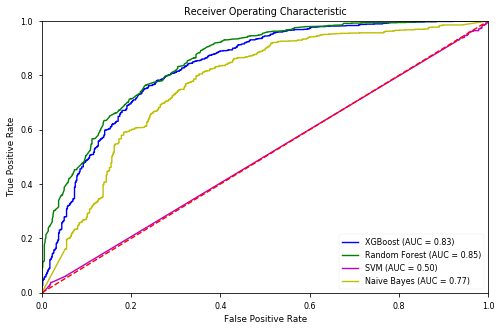

In [135]:
results = compare_models(X, y)

### Without Action Columns

[IterativeImputer] Completing matrix with shape (6266, 200)
[IterativeImputer] Ending imputation round 1/10, elapsed time 12.85
[IterativeImputer] Change: 210329.031168163, scaled tolerance: 130000000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1567, 200)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.08
Fitting XGBoost...

XGBoost Fitted!
Total Time Elapsed - 0:0:1
---------------------------------------------------
Predicting on validation data...
Predictions Completed
Total Time Elapsed - 0:0:1
---------------------------------------------------
ROC-AUC Score: 76.68%
Accuracy Score: 73.26%
Precision Score: 77.90%
Recall Score: 81.39%
F1 Score: 79.61%
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.59      0.61       562
           1       0.78      0.81      0.80      1005

    accuracy          

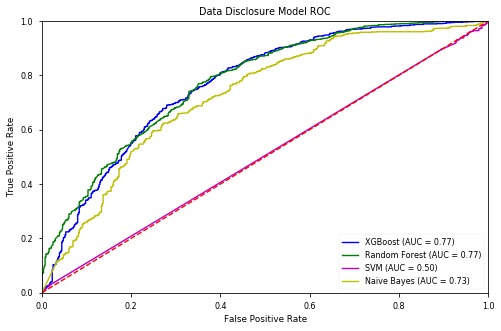

In [145]:
results_noaction = compare_models(X_noaction, y, action_cols, title='Data Disclosure Model ROC')

In [148]:
results_noaction.to_clipboard()

## Interpretability (without tuning)

In [87]:
preprocessor = Pipeline(([
    ('encoder', MEstimateEncoder(cols=[col for col in cat_cols if col not in action_cols])),
    ('imputer', IterativeImputer(verbose=2))
]))
sampler = ADASYN()

print('Preprocessing data...')

X_preprocessed = preprocessor.fit_transform(X_noaction, y)

print('Resampling data...')
X_resampled, y_resampled = sampler.fit_resample(X_preprocessed, y)

print('Fiting XGBoost...')
xgb = XGBClassifier(verbose = 3)
xgb.fit(X_resampled, y_resampled)

print('SHAP explanations...')
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_resampled)

Preprocessing data...
[IterativeImputer] Completing matrix with shape (7833, 205)
[IterativeImputer] Ending imputation round 1/10, elapsed time 19.21
[IterativeImputer] Change: 7017418.893061187, scaled tolerance: 6800000000.0 
[IterativeImputer] Early stopping criterion reached.
Resampling data...
Fiting XGBoost...
SHAP explanations...


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


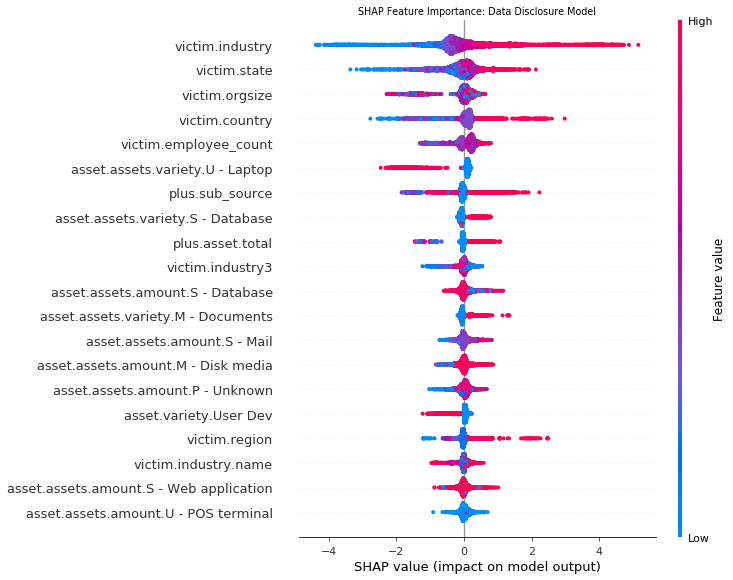

In [88]:
plt.title('SHAP Feature Importance: Data Disclosure Model')
shap.summary_plot(shap_values, pd.DataFrame(X_resampled, columns=X_noaction.columns))

In [ ]:
def plot_roc(y_test, y_proba):
    fpr, tpr, threshold = roc_curve(y_test, y_proba)
    # fpr, tpr, threshold = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    # method I: plt
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    

### XGBoost

In [ ]:
xgb = XGBClassifier(verbose = 3)
t0 = datetime.datetime.now()
print('---------------------------------------------------')

print('Fitting XGBoost...')
xgb.fit(X_train_resampled, y_train_resampled)

print('XGBoost Fitted!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))

print('---------------------------------------------------')
print('Predicting on validation data...')
y_pred_probas = xgb.predict_proba(X_val_preprocessed)
y_pred_proba = y_pred_probas[:,1]
y_pred = xgb.predict(X_val_preprocessed)

print('Predictions Completed')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
print('---------------------------------------------------')
print('ROC-AUC Score: {:.2%}'.format(roc_auc_score(y_val, y_pred_proba)))
print('Accuracy Score: {:.2%}'.format(accuracy_score(y_val, y_pred)))
print('Precision Score: {:.2%}'.format(precision_score(y_val, y_pred)))
print('Recall Score: {:.2%}'.format(recall_score(y_val, y_pred)))
print('---------------------------------------------------')
print('Classification Report:')
print(classification_report(y_val, y_pred))
print('---------------------------------------------------')
print('\nConfusion Matrix:')
confusion = pd.DataFrame(confusion_matrix(y_val, y_pred)).loc[range(2), range(2)]
print(confusion)

plot_roc(y_val, y_pred_proba)

## Model Interpretability

#### Example Visualisation of one prediction

In [79]:
shap.force_plot(explainer.expected_value, 
                shap_values[0,:], 
                pd.DataFrame(X_train_resampled, 
                             columns=X_train.dropna(axis='columns', how='all').columns
                            ).iloc[0,:]
               )

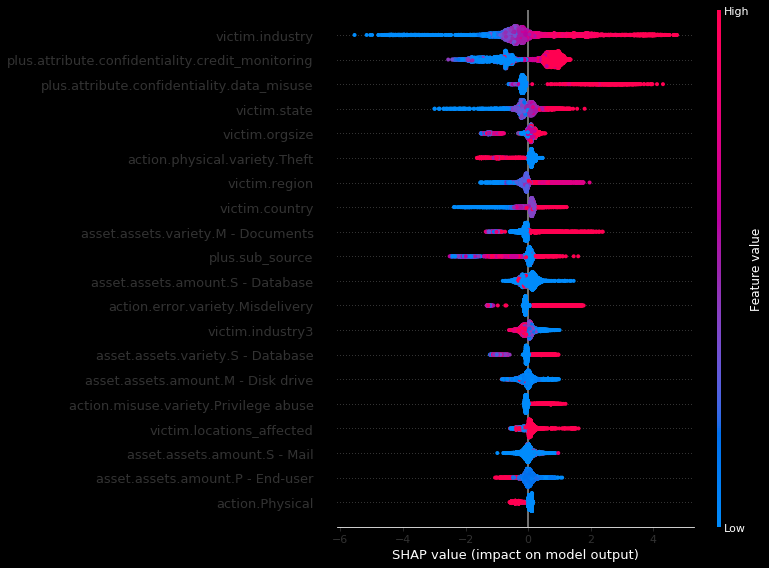

In [80]:
shap.summary_plot(shap_values, pd.DataFrame(X_train_resampled, columns=X_train.dropna(axis='columns', how='all').columns))

In [81]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_val_preprocessed.iloc[0,:], link="logit")

IndexError: invalid index to scalar variable.

## Hyperparameter Tuning using Particle Swarm Optimisation

In [90]:
import optunity
import optunity.metrics

In [107]:
# Define our Objective Function
@optunity.cross_validated(x=X_train.values, y=y_train.values, num_folds=3)
# @optunity.cross_validated(x=X_train_resampled, y=y_train_resampled.values, num_folds=5)
def xgb_tuned_recall(x_train, y_train, x_test, y_test, 
                     # These are the hyperparameters we wish to tune
                     n_estimators,
                     max_depth, 
                     min_child_weight, 
                     gamma, 
                     colsample_bytree,
                     subsample,
                     reg_alpha, 
                     reg_lambda):
    
    # categorical encoding
    print('M-encoding categoricals')
    x_train_df = pd.DataFrame(x_train, columns = X_noaction.columns)
    x_test_df = pd.DataFrame(x_test, columns = X_noaction.columns)
    cat_cols = list(x_train_df.select_dtypes('O').columns)
    assert all([col in x_train_df for col in cat_cols])
    
    m_encoder = MEstimateEncoder(cols=cat_cols)
    x_train_enc = m_encoder.fit_transform(x_train_df, y_train)
    x_test_enc = m_encoder.transform(x_test_df)
    
    # imputation
    print('Imputing nulls')
    imputer = IterativeImputer(verbose=2)
    x_train_imp = imputer.fit_transform(x_train_enc)
    x_test = imputer.transform(x_test_enc)
        
    # oversampling
    print('Oversampling')
    oversampler = ADASYN()
    x_train, y_train = oversampler.fit_resample(x_train_imp, y_train)
    
    print('Fitting Model')
    model = (
        # instanciate classifier every evaluation
        XGBClassifier(n_estimators = round(n_estimators), 
                      max_depth = round(max_depth),
                      min_child_weight = min_child_weight,
                      gamma = gamma,
                      colsample_bytree = colsample_bytree,
                      subsample = subsample,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      verbose = 3
                     )
            # fit model
            ).fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    score = recall_score(y_test, y_pred)
    print('Recall Score= {:.2%}'.format(score), '| Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))
    return score

t0 = datetime.datetime.now()
print('Tuning XGBoost...')
print('----------------------------\n')

xgb_optimum, details, _ = optunity.maximize(xgb_tuned_recall, 
                                            num_evals = 100, 
                                            # define hyperparameter grid
                                            n_estimators = [100, 1000], 
                                            max_depth = [2, 10], 
                                            min_child_weight = [1, 7],
                                            gamma = [0.1, 2],
                                            colsample_bytree = [0.3, 1],
                                            subsample = [0.2, 0.7],
                                            reg_alpha = [0, 1],
                                            reg_lambda = [1, 5]
                                           )

print('Tuning Completed!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))

Tuning XGBoost...
----------------------------

M-encoding categoricals
Imputing nulls
[IterativeImputer] Completing matrix with shape (4178, 205)
[IterativeImputer] Ending imputation round 1/10, elapsed time 8.70
[IterativeImputer] Change: 0.0, scaled tolerance: 0.0009838113059750207 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (2088, 205)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.00
Oversampling
Fitting Model
Recall Score= 77.19% | Total Time Elapsed - 0:0:15
M-encoding categoricals
Imputing nulls
[IterativeImputer] Completing matrix with shape (4177, 205)
[IterativeImputer] Ending imputation round 1/10, elapsed time 9.00
[IterativeImputer] Change: 0.0, scaled tolerance: 0.000973352240290234 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (2089, 205)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.00
Oversampling
Fitting Model
Recall Score

In [108]:
xgb_optimum['n_estimators'] = round(xgb_optimum['n_estimators'])
xgb_optimum['max_depth'] = round(xgb_optimum['max_depth'])
xgb_optimum

{'n_estimators': 451,
 'max_depth': 6,
 'min_child_weight': 2.259765625,
 'gamma': 1.93876953125,
 'colsample_bytree': 0.6124023437499999,
 'subsample': 0.69072265625,
 'reg_alpha': 0.8779296875,
 'reg_lambda': 3.77734375}

In [ ]:
xgb_optimum = {
    'n_estimators': 451,
    'max_depth': 6,
    'min_child_weight': 2.259765625,
    'gamma': 1.93876953125,
    'colsample_bytree': 0.6124023437499999,
    'subsample': 0.69072265625,
    'reg_alpha': 0.8779296875,
    'reg_lambda': 3.77734375
}

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X_noaction, y, test_size=0.2, random_state=42)

xgb_preprocessor = Pipeline(([
    ('encoder', MEstimateEncoder(cols=[col for col in cat_cols if col not in action_cols])),
    ('imputer', IterativeImputer(verbose=2))
]))

print('Preprocessing data...')
X_train_preprocessed = xgb_preprocessor.fit_transform(X_train, y_train)
X_test_preprocessed = xgb_preprocessor.transform(X_test)

xgb_sampler = ADASYN()
print('Resampling data...')
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_preprocessed, y_train)

print('Preprocessing Completed.')
print('----------------------------\n')

Preprocessing data...
[IterativeImputer] Completing matrix with shape (6266, 200)
[IterativeImputer] Ending imputation round 1/10, elapsed time 10.49
[IterativeImputer] Change: 210329.031168163, scaled tolerance: 130000000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (1567, 200)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.07
Resampling data...
Preprocessing Completed.
----------------------------



In [159]:
xgb = XGBClassifier(**xgb_optimum)
t0 = datetime.datetime.now()
print('Fitting XGBoost...')
print('----------------------------\n')
xgb.fit(X_train_resampled, y_train_resampled)

print('XGBoost Fitted!')
print('Total Time Elapsed - %s'%format_timedelta(datetime.datetime.now()-t0))

print('Predicting on validation data...')
print('----------------------------\n')
y_pred_proba = xgb.predict_proba(X_test_preprocessed)[:,1]
y_pred = xgb.predict(X_test_preprocessed)

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred)

print('ROC-AUC Score: {:.2%}'.format(roc_auc))
print('Accuracy Score: {:.2%}'.format(accuracy))
print('Precision Score: {:.2%}'.format(precision))
print('Recall Score: {:.2%}'.format(recall))
print('F1 Score: {:.2%}'.format(f1))
print('---------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('---------------------------------------------------')
print('\nConfusion Matrix:')
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred)).loc[range(2), range(2)]
print(confusion)
print('\n\n===================================================')
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)
# fpr, tpr, threshold = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

Fitting XGBoost...
----------------------------

XGBoost Fitted!
Total Time Elapsed - 0:0:3
Predicting on validation data...
----------------------------

ROC-AUC Score: 76.05%
Accuracy Score: 72.50%
Precision Score: 77.18%
Recall Score: 81.09%
F1 Score: 79.09%
---------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.57      0.60       562
           1       0.77      0.81      0.79      1005

    accuracy                           0.72      1567
   macro avg       0.70      0.69      0.69      1567
weighted avg       0.72      0.72      0.72      1567

---------------------------------------------------

Confusion Matrix:
     0    1
0  321  241
1  190  815




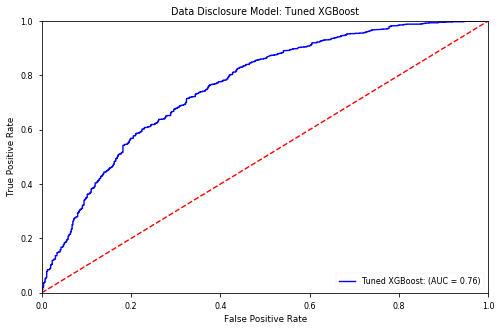

In [160]:
fig = plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, 'b', label = 'Tuned XGBoost: (AUC = %0.2f)' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Data Disclosure Model: Tuned XGBoost')
plt.savefig('figs/results_figs/data_disclosure/tuned_xgb_disclosure.png')
plt.show()

## Interpretability (with tuning)

In [339]:
preprocessor = Pipeline(([
    ('encoder', MEstimateEncoder(cols=[col for col in cat_cols if col not in action_cols])),
    ('imputer', IterativeImputer(verbose=2))
]))
sampler = ADASYN()

print('Preprocessing data...')

X_preprocessed = preprocessor.fit_transform(X_noaction, y)

print('Resampling data...')
X_resampled, y_resampled = sampler.fit_resample(X_preprocessed, y)

print('Fiting XGBoost...')
xgb = XGBClassifier(**xgb_optimum)
xgb.fit(X_resampled, y_resampled)

print('SHAP explanations...')
shap_explainer = shap.TreeExplainer(xgb)
shap_values = shap_explainer.shap_values(X_resampled)

Preprocessing data...
[IterativeImputer] Completing matrix with shape (7833, 205)
[IterativeImputer] Ending imputation round 1/10, elapsed time 16.49
[IterativeImputer] Change: 7017418.893061187, scaled tolerance: 6800000000.0 
[IterativeImputer] Early stopping criterion reached.
Resampling data...
Fiting XGBoost...
SHAP explanations...


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


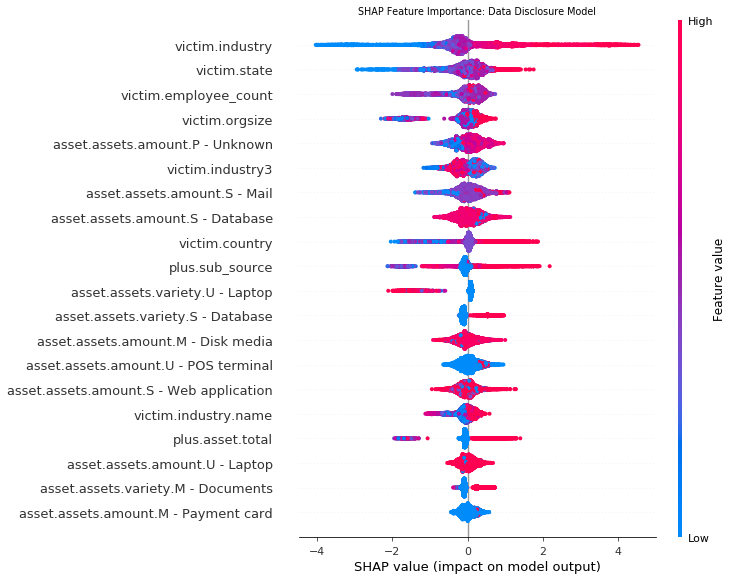

In [340]:
plt.title('SHAP Feature Importance: Data Disclosure Model')
shap.summary_plot(shap_values, pd.DataFrame(X_resampled, columns=X_noaction.columns), show=False)
plt.savefig('figs/results_figs/data_disclosure/tuned_xgb_SHAP.png')
plt.show()

In [366]:
sample = pd.DataFrame(X_resampled, columns=X_noaction.columns).sample(1).iloc[0]
sample_idx = sample.name
shap.force_plot(shap_explainer.expected_value, shap_values[sample_idx], pd.DataFrame(X_resampled, columns=X_noaction.columns).iloc[sample_idx,:], link="logit")

In [367]:
lime_explainer = lime_tabular.LimeTabularExplainer(X_resampled, 
                                                   training_labels=y_resampled, 
                                                   feature_names=X_noaction.columns, 
                                                   class_names=[False, True])
lime_exp = lime_explainer.explain_instance(X_resampled[sample_idx], xgb.predict_proba, num_features=10, labels=(1,))
lime_exp.show_in_notebook()

In [332]:
help(lime_tabular.LimeTabularExplainer)

Help on class LimeTabularExplainer in module lime.lime_tabular:

class LimeTabularExplainer(builtins.object)
 |  LimeTabularExplainer(training_data, mode='classification', training_labels=None, feature_names=None, categorical_features=None, categorical_names=None, kernel_width=None, kernel=None, verbose=False, class_names=None, feature_selection='auto', discretize_continuous=True, discretizer='quartile', sample_around_instance=False, random_state=None, training_data_stats=None)
 |  
 |  Explains predictions on tabular (i.e. matrix) data.
 |  For numerical features, perturb them by sampling from a Normal(0,1) and
 |  doing the inverse operation of mean-centering and scaling, according to the
 |  means and stds in the training data. For categorical features, perturb by
 |  sampling according to the training distribution, and making a binary
 |  feature that is 1 when the value is the same as the instance being
 |  explained.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, training

# Anchor Explainer

In [253]:
from anchor import utils
from anchor import anchor_tabular

In [228]:
cat_cols

['action.hacking.cve',
 'action.malware.cve',
 'action.malware.name',
 'control_failure',
 'plus.asset.total',
 'plus.f500',
 'plus.sub_source',
 'victim.industry',
 'victim.region',
 'victim.state',
 'victim.industry2',
 'victim.industry3',
 'victim.industry.name',
 'confidence',
 'victim.employee_count',
 'victim.country',
 'victim.revenue.iso_currency_code',
 'victim.orgsize',
 'cost_corrective_action',
 'asset.cloud',
 'asset.accessibility',
 'asset.country',
 'plus.attack_difficulty_initial',
 'plus.attack_difficulty_legacy',
 'plus.attack_difficulty_subsequent',
 'plus.unknown_unknowns']

In [321]:
explainer = anchor_tabular.AnchorTabularExplainer(
    ['No', 'Yes'],
    X_noaction.columns,
    X_resampled)

LIME

In [284]:
pd.DataFrame(X_resampled, columns=X_noaction.columns)

,asset.assets.amount.M - Disk drive,asset.assets.amount.M - Disk media,asset.assets.amount.M - Documents,asset.assets.amount.M - Flash drive,asset.assets.amount.M - Other,asset.assets.amount.M - Payment card,asset.assets.amount.M - Smart card,asset.assets.amount.M - Tapes,asset.assets.amount.N - Camera,asset.assets.amount.N - PLC,...,victim.revenue.iso_currency_code,victim.orgsize,cost_corrective_action,asset.cloud,asset.accessibility,asset.country,plus.attack_difficulty_initial,plus.attack_difficulty_legacy,plus.attack_difficulty_subsequent,plus.unknown_unknowns
0,2.796103,39.357691,7317.797859,2.000068,2193.867261,1.083844,1.0,5.0,1.0,1.0,...,0.648497,0.694617,0.648148,0.648323,0.648427,0.648366,0.647794,0.650905,0.647835,0.647931
1,2.796026,39.359349,7317.673603,2.000039,2193.773692,1.084070,1.0,5.0,1.0,1.0,...,0.648497,0.587924,0.648148,0.648323,0.648427,0.648366,0.647794,0.650905,0.647835,0.647931
2,2.796031,39.356731,7317.679782,2.000039,2193.778340,1.084058,1.0,5.0,1.0,1.0,...,0.648497,0.694617,0.648148,0.648323,0.648427,0.648366,0.647794,0.650905,0.647835,0.647931
3,2.796048,39.356116,7317.707326,2.000047,2193.799760,1.084008,1.0,5.0,1.0,1.0,...,0.648497,0.647619,0.648148,0.648323,0.648427,0.648366,0.647794,0.650905,0.647835,0.647931
4,2.796025,39.357238,7317.670354,2.000039,2193.770982,1.084075,1.0,5.0,1.0,1.0,...,0.648497,0.694617,0.648148,0.648323,0.648427,0.648366,0.647794,0.650905,0.647835,0.647931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10109,2.796025,39.356614,7317.670390,2.000039,2193.771228,1.084075,1.0,5.0,1.0,1.0,...,0.648497,0.672983,0.648148,0.648323,0.648427,0.648366,0.647794,0.650905,0.647835,0.647931
10110,1.019903,1.003023,4413.983637,1.333153,0.995471,6.345999,1.0,5.0,1.0,1.0,...,0.648497,0.651171,0.648148,0.648323,0.648427,0.648366,0.647794,0.650905,0.647835,0.647931
10111,2.795981,41.322263,7317.784109,2.000065,2193.859471,1.084163,1.0,5.0,1.0,1.0,...,0.648497,0.636816,0.648148,0.648323,0.648427,0.648366,0.647794,0.650905,0.647835,0.647931
10112,2.795981,41.322214,7317.784117,2.000065,2193.859485,1.084163,1.0,5.0,1.0,1.0,...,0.648497,0.662882,0.648148,0.648323,0.648427,0.648366,0.647794,0.650905,0.647835,0.647931


In [256]:
X_resampled[0,:].reshape(1, -1).shape

(1, 205)

In [260]:
xgb.predict(X_resampled[0,:].reshape(1, -1))

array([1])

In [288]:
eg = pd.DataFrame(X_resampled).iloc[0]

In [278]:
print('Prediction: ', explainer.class_names[xgb.predict(eg.values.reshape(1, -1))[0]])

Prediction:  Yes


In [282]:
help(explainer.explain_instance)

Help on method explain_instance in module anchor.anchor_tabular:

explain_instance(data_row, classifier_fn, threshold=0.95, delta=0.1, tau=0.15, batch_size=100, max_anchor_size=None, desired_label=None, beam_size=4, **kwargs) method of anchor.anchor_tabular.AnchorTabularExplainer instance



In [310]:
def xgb_predict(data_row):
    return xgb.predict(data_row.values)

In [317]:
exp = explainer.explain_instance(eg,  xgb.predict, threshold=0.95, desired_label=1)

AttributeError: 'Series' object has no attribute 'reshape'

In [319]:
c = RandomForestClassifier(n_estimators=50, n_jobs=5)

In [320]:
c.fit(X_resampled, y_resampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=5,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [326]:
exp = explainer.explain_instance(X_resampled[0,:],  c.predict, threshold=0.95)

AttributeError: 'AnchorTabularExplainer' object has no attribute 'validation'

In [223]:
preprocessor['encoder'].mapping['control_failure']

control_failure
 1    0.647983
 2    0.824014
-1    0.648028
-2    0.648028
dtype: float64